In [84]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from scipy import ndimage as ndi
import skimage as skim
from skimage import feature
import pandas as pd
import xarray as xr
plt.rcParams['figure.figsize'] = (10,8)
import pickle as pkl
from mre import pytorch_unet

# Load mre data
full_data_dir = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/'
ds = pkl.load(open(full_data_dir+'mre_ds_preprocess_2.p', 'rb'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ds

<xarray.Dataset>
Dimensions:      (sequence: 10, subject: 50, x: 256, y: 256, z: 4)
Coordinates:
  * subject      (subject) <U3 '148' '162' '163' '178' ... '404' '405' '406'
  * sequence     (sequence) <U8 'T1Pre' 'T1Pos' 'T2FR' ... 'extra2' 'extra3'
Dimensions without coordinates: x, y, z
Data variables:
    image        (subject, sequence, z, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0
    age          (subject) int8 -59 -27 -91 -107 117 ... -107 -107 5 -59 101
    z_space      (subject, sequence) float16 13.8 10.0 10.0 10.0 ... 0.0 0.0 0.0
    z_space_std  (subject) float16 1.684 1.684 3.826 1.2 ... 3.812 1.049 2.854

In [3]:
print(ds.sequence)
print(ds.subject[0])

<xarray.DataArray 'sequence' (sequence: 10)>
array(['T1Pre', 'T1Pos', 'T2FR', 'T2SS', 'elastMsk', 'elast', 'msk', 'extra1',
       'extra2', 'extra3'], dtype='<U8')
Coordinates:
  * sequence  (sequence) <U8 'T1Pre' 'T1Pos' 'T2FR' ... 'extra2' 'extra3'
<xarray.DataArray 'subject' ()>
array('148', dtype='<U3')
Coordinates:
    subject  <U3 '148'


In [6]:
# Use xArray to define the dataset.  Easy to query and map (although might not be fast when scaling up)
input_example = ds.sel(sequence=['T2SS', 'T1Pre', 'T1Pos', 'T2FR']).image
target_example = ds.sel(sequence=['elast']).image

In [7]:
input_example.values.shape

(50, 4, 4, 256, 256)

In [87]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

# need data to be ordered thusly:
# image_sequence,width,hight,depth
class MREDataset(Dataset):
    def __init__(self, xa_ds, set_type='train', transform=None):
        inputs = ['T1Pre', 'T1Pos', 'T2SS', 'T2FR']
        targets = ['elast']
        
        # stack subject and z-slices to make 4 2D image groups for each 3D image group
        xa_ds = xa_ds.stack(subject_2d = ('subject', 'z')).reset_index('subject_2d')
        subj_2d_coords = [f'{i.subject.values}_{i.z.values}' for i in xa_ds.subject_2d]
        xa_ds.assign_coords(subject_2d=subj_2d_coords)
        self.name_dict = dict(zip(range(len(subj_2d_coords)), subj_2d_coords))
        
        if set_type == 'train':
            input_set = xa_ds.subject_2d[:-20]
        elif set_type == 'val':
            input_set = xa_ds.subject_2d[-20:]
        else:
            raise AttributeError('Must choose one of ["train", "val"] for `set_type`.')
            
        
        self.input_images = xa_ds.sel(sequence=inputs, subject_2d=input_set).transpose(
            'subject_2d', 'sequence', 'y', 'x').image.values
        #ds.sel(sequence=inputs, subject=subjects).stack(subject_2d=('subject','z')).transpose('subject_2d','sequence', 'y', 'x').image.values.shape
        self.target_images = xa_ds.sel(sequence=targets, subject_2d=input_set).transpose(
            'subject_2d', 'sequence', 'y', 'x').image.values
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        target = self.target_images[idx]
        image = torch.Tensor(image)
        target = torch.Tensor(target)
        if self.transform:
            image = self.transform(image)
            target = self.transform(target)
        
        return [image, target]

# use same transform for train/val for this example
#trans = transforms.Compose([
#   torch.Tensor(),
#])
trans=None

train_set = MREDataset(ds, set_type='train', transform = trans)
val_set = MREDataset(ds, set_type='val', transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 5

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 180, 'val': 20}

In [86]:
#inputs = ['T1Pre', 'T1Pos', 'T2SS', 'T2FR']
#targets = ['elast']
#subjects = ['365', '368']
#ds_stack = ds.sel(sequence=inputs, subject=subjects).stack(subject_2d=('subject','z'))

In [57]:
#ds_stack = ds_stack.reset_index('subject_2d')
#subj_2d_coords = [f'{i.subject.values}_{i.z.values}' for i in ds_stack.subject_2d]
#ds_stack.assign_coords(subject_2d=subj_2d_coords)

<xarray.Dataset>
Dimensions:      (sequence: 4, subject_2d: 8, x: 256, y: 256)
Coordinates:
  * sequence     (sequence) <U8 'T1Pre' 'T1Pos' 'T2SS' 'T2FR'
    subject      (subject_2d) object '365' '365' '365' ... '368' '368' '368'
    z            (subject_2d) int64 0 1 2 3 0 1 2 3
  * subject_2d   (subject_2d) <U5 '365_0' '365_1' '365_2' ... '368_2' '368_3'
Dimensions without coordinates: x, y
Data variables:
    image        (sequence, y, x, subject_2d) float32 4.0 3.0 5.0 ... 0.0 0.0
    age          (subject_2d) int8 -27 -27 -27 -27 -59 -59 -59 -59
    z_space      (sequence, subject_2d) float16 11.5 11.5 11.5 ... 9.0 9.0 9.0
    z_space_std  (subject_2d) float16 2.854 2.854 2.854 ... 0.743 0.743 0.743

In [88]:
def torch_dl_vis(inputs, targets):
    print('lol')
    titles = ['T1Pre', 'T1Pos', 'T2SS', 'T2FR', 'elast']
    n_input = inputs.shape[0]
    n_seq = inputs.shape[1]+targets.shape[1]
    fig, axes = plt.subplots(n_input, n_seq, tight_layout=True, figsize=(2.5*n_seq,2.5*n_input), sharex=True, sharey=True)
    for i in range(n_input):
        for seq in range(n_seq):
            if seq < inputs.shape[1]:
                #set_trace()
                axes[i][seq].imshow(np.asarray(inputs[i,seq,:,:]))
            else:
                axes[i][seq].imshow(np.asarray(targets[i,seq-inputs.shape[1],:,:]))
    
            axes[i][seq].axis('off')
            if i == 0:
                axes[i][seq].set_title(titles[seq])
        if seq == 0:
            axes[i][seq].set_xlabel(f'subj = {i}')
    fig.lines.append(plt.vlines(0.8, 0, 1, transform=fig.transFigure))
    plt.show()

torch.Size([5, 4, 256, 256])
torch.Size([5, 1, 256, 256])
lol


/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


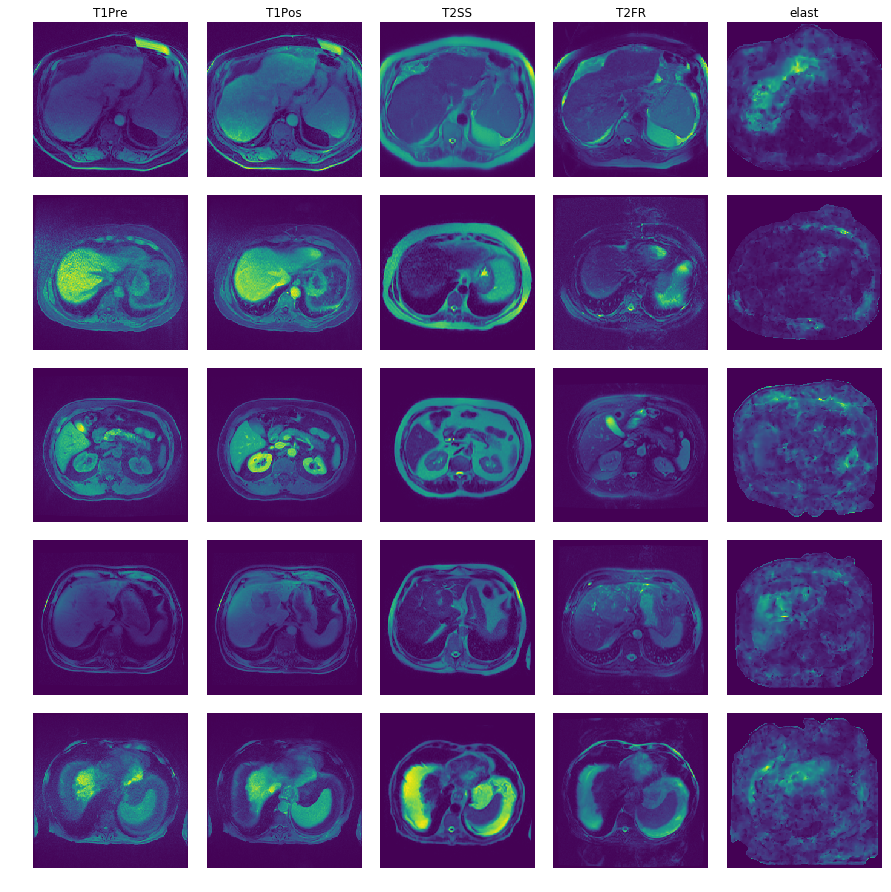

In [89]:
import torchvision.utils

# Get a batch of training data
inputs, targets= next(iter(dataloaders['train']))

#print(inputs.shape, masks.shape)
#for x in [inputs.numpy(), masks.numpy()]:
#    print(x.min(), x.max(), x.mean(), x.std())
print(inputs.shape)
print(targets.shape)

torch_dl_vis(inputs, targets)

In [90]:
from torchsummary import summary
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = pytorch_unet.UNet(1)
model = model.to(device)

summary(model, input_size=(4, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           2,368
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [93]:
from collections import defaultdict
import torch.nn.functional as F
#from loss import dice_loss

#criterion = nn.MSELoss()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    #bce = F.binary_cross_entropy_with_logits(pred, target)
        
    #pred = F.sigmoid(pred)
    #dice = dice_loss(pred, target)
    
    #loss = bce * bce_weight + dice * (1 - bce_weight)
    loss = F.mse_loss(pred, target)
    
    #metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    #metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [96]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 1

model = pytorch_unet.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

cuda:0
Epoch 0/39
----------
LR 0.0001


/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


train: loss: 4059033.701389
val: loss: 5717415.250000
saving best model
0m 6s
Epoch 1/39
----------
LR 0.0001
train: loss: 4470777.184028
val: loss: 3624020.843750
saving best model
0m 6s
Epoch 2/39
----------
LR 0.0001
train: loss: 2493348.381944
val: loss: 3436207.437500
saving best model
0m 6s
Epoch 3/39
----------
LR 0.0001
train: loss: 2518903.256944
val: loss: 3261070.250000
saving best model
0m 6s
Epoch 4/39
----------
LR 0.0001
train: loss: 2530230.836806
val: loss: 3543967.312500
0m 6s
Epoch 5/39
----------
LR 0.0001
train: loss: 2396079.237847
val: loss: 3292406.437500
0m 6s
Epoch 6/39
----------
LR 0.0001
train: loss: 2384942.465278
val: loss: 3370296.171875
0m 6s
Epoch 7/39
----------
LR 0.0001
train: loss: 2394280.274306
val: loss: 3322052.093750
0m 6s
Epoch 8/39
----------
LR 0.0001
train: loss: 2324025.934028
val: loss: 3580687.843750
0m 6s
Epoch 9/39
----------
LR 0.0001
train: loss: 2413758.958333
val: loss: 3244206.062500
saving best model
0m 6s
Epoch 10/39
----------

(3, 1, 256, 256)


/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


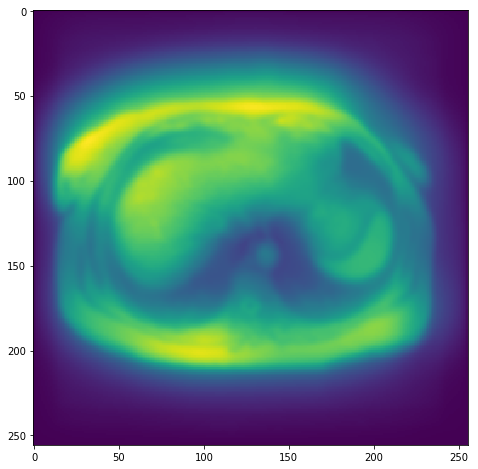

In [98]:
# prediction

import math

model.eval()   # Set model to evaluate mode

test_loader =  DataLoader(val_set, batch_size=3, shuffle=True, num_workers=0)
#test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)
plt.imshow(pred[0][0])

# Change channel-order and make 3 channels for matplot
#input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
#target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
#pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

#helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])